<a href="https://colab.research.google.com/github/MasoudMoeini/Absenteeism-At-Work/blob/main/Eyefixation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
import numpy as np
import matplotlib . pyplot as plt
from kld import KLD

In [7]:
!unzip -qq ccv_data.zip

In [4]:
x = tf.placeholder(tf.float32, (None, 224, 224, 3)) # input image
y = tf.placeholder(tf.float32, (None, 224, 224, 1)) # target eye fixation map

conv1 = tf.layers.conv2d(x, filters=32, kernel_size=[3,3], padding="same", activation=tf.nn.relu)
conv2 = tf.layers.conv2d(conv1, filters=32, kernel_size=[3,3], padding="same", activation=tf.nn.relu)
pool1 = tf.layers.max_pooling2d(conv2, pool_size=[2,2], strides=2, padding="same")

conv3 = tf.layers.conv2d(conv2, filters=64, kernel_size=[3,3], padding="same", activation=tf.nn.relu)
conv4 = tf.layers.conv2d(conv3, filters=64, kernel_size=[3,3], padding="same", activation=tf.nn.relu)
pool2 = tf.layers.max_pooling2d(conv4, pool_size=[2,2], strides=2, padding="same")

conv5 = tf.layers.conv2d(pool2, filters=128, kernel_size=[3,3], padding="same", activation=tf.nn.relu)
conv6 = tf.layers.conv2d(conv5, filters=128, kernel_size=[3,3], padding="same", activation=tf.nn.relu)
pool3 = tf.layers.max_pooling2d(conv6, pool_size=[2,2], strides=1, padding="same")

conv7 = tf.layers.conv2d(pool3, filters=128, kernel_size=[3,3], padding="same", activation=tf.nn.relu)
conv8 = tf.layers.conv2d(conv7, filters=128, kernel_size=[3,3], padding="same", activation=tf.nn.relu)

multilevel_features = tf.concat([pool2, pool3, conv8], axis=3)

conv9 = tf.layers.conv2d(multilevel_features, filters=64, kernel_size=[3,3], padding="same", activation=tf.nn.relu)
conv10 = tf.layers.conv2d(conv9, filters=1, kernel_size=[1,1], padding="same", activation=tf.nn.relu)
upsampled_output = tf.image.resize_images(conv10, (224, 224), method=tf.image.ResizeMethod.BICUBIC )

# Normalize output fixation maps
wmax = tf.reduce_max(upsampled_output, axis=2, keepdims=True) # along width dimension
output_max = tf.reduce_max(wmax, axis=1, keepdims=True) # along height dimension
normalized_output = upsampled_output / output_max

# Loss function
alpha = 1.1
loss = tf.reduce_mean( tf.square( (1.0/(alpha - y)) * (normalized_output - y) ))
loss_summary = tf.summary.scalar(name="loss", tensor=loss)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: UserWarning: `tf.layers.conv2d` is deprecated and will be removed in a future version. Please Use `tf.keras.layers.Conv2D` instead.
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/keras/legacy_tf_layers/convolutional.py:575: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  return layer.apply(inputs)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning: `tf.layers.conv2d` is deprecated and will be removed in a future version. Please Use `tf.keras.layers.Conv2D` instead.
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: UserWarning: `tf.layers.max_pooling2d` is deprecated and will be removed in a future version. Please use `tf.keras.layers.MaxPooling2D` instead.
  
/usr/local/lib/python3.7/dist-packages/keras/legacy_tf_layers/pooling.py:600: UserWarning: `layer.apply` is dep

In [20]:
from datareader import DataReader
from testdatareader import TDataReader
from PIL import Image
import os
train_data = DataReader('ccv_data/train')
val_data =  DataReader('ccv_data/val')
test_data=TDataReader('ccv_data/test')
batchsize = 50
validation_interval = 50
use_checkpoint = False
num_training_images = train_data.num_images
num_test_images=test_data.num_images
num_training_batches_per_epoch = train_data.num_batches_of_size(batchsize)
num_validation_batches_per_epoch = val_data.num_batches_of_size(batchsize)

num_test_batches_per_epoch = test_data.num_batches_of_size(batchsize)
momentum = 0.5
num_batches = train_data.num_batches_of_size(batchsize)
gradient_descent = tf.train.MomentumOptimizer(0.001, momentum=momentum, use_locking=False, name='Momentum', use_nesterov=False)
 
train=gradient_descent.minimize(loss)
saver = tf.train.Saver()
for i in range(3):
        print('iteration' + str(i))
        with tf.Session() as sess:
            summary_writer = tf.summary.FileWriter(logdir="./logs/", graph=sess.graph)

            if use_checkpoint:
                    saver.restore(sess, "Models/my-model-100") 
            else:
                    sess.run(tf.global_variables_initializer())

            for b in range(num_batches):
                    images, fixations, images_to_read = train_data.get_batch(batchsize)

                    batch_loss, batch_loss_summary, _ = sess.run([loss, loss_summary, train], feed_dict={x: images, y: fixations})
                    summary_writer.add_summary(batch_loss_summary, global_step=b)
                    print('Batch ' + str(b) + ', loss: ' + str(batch_loss))

                    if b % validation_interval == 0:
                            print('Running validation')
                            total_eval_loss = 0.0
                            prediction_directory = 'predictions/predictions_' + str(b)
                            if not os.path.exists(prediction_directory):
                                os.makedirs(prediction_directory)

                            # Validation loop with saving of predictions
                            for vb in range(num_validation_batches_per_epoch):
                                val_images, val_fixations, val_filenames = val_data.get_batch(batchsize)
                                batch_eval_loss, predictions = sess.run([loss, normalized_output], feed_dict={x: val_images, y: val_fixations})
                                total_eval_loss += batch_eval_loss

                                for p, fn in zip(predictions, val_filenames):
                                    prediction_name = os.path.join(prediction_directory, fn)
                                    p_arr = (p * 255.0).astype(np.uint8)
                                    p_image = Image.fromarray(p_arr[:,:,0])
                                    p_image.save(prediction_name)

                            avg_eval_loss = total_eval_loss / num_validation_batches_per_epoch
                            print('Average validation loss: ' + str(avg_eval_loss))
                            summary = tf.Summary()
                            summary.value.add(tag="validation_loss", simple_value=avg_eval_loss)
                            summary_writer.add_summary(summary, global_step=b)

            # Save the current model after running validation
                            saver_path = saver.save(sess, "Models/my-model", global_step=b)
#prediction with test set

iteration0
Batch 0, loss: 0.21843904
Running validation
Average validation loss: 0.18534576892852783
Batch 1, loss: 0.17487992
Batch 2, loss: 0.18543144
Batch 3, loss: 0.15681498
Batch 4, loss: 0.1703044
Batch 5, loss: 0.14509593
Batch 6, loss: 0.1391037
Batch 7, loss: 0.14999755
Batch 8, loss: 0.14320561
Batch 9, loss: 0.1813317
Batch 10, loss: 0.163919
Batch 11, loss: 0.16282552
Batch 12, loss: 0.16275749
Batch 13, loss: 0.16421217
Batch 14, loss: 0.17796648
Batch 15, loss: 0.1413898
Batch 16, loss: 0.19392668
Batch 17, loss: 0.1504085
Batch 18, loss: 0.1452744
Batch 19, loss: 0.14072616
Batch 20, loss: 0.13718964
Batch 21, loss: 0.13413303
Batch 22, loss: 0.13458605
Batch 23, loss: 0.1585881
iteration1
Batch 0, loss: 0.18739912
Running validation
Average validation loss: 0.18601479567587376
Batch 1, loss: 0.18749222
Batch 2, loss: 0.31258893
Batch 3, loss: 0.2865544
Batch 4, loss: 0.22521187
Batch 5, loss: 0.13518889
Batch 6, loss: 0.19687575
Batch 7, loss: 0.16665855
Batch 8, loss:

In [21]:
from testdatareader import TDataReader
from PIL import Image
import numpy as np
batchsize = 1
test_data=TDataReader('ccv_data/test')
A=np.arange(1601, stop=2001, step=1, dtype=np.integer)  
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    for vb in A:
            images,test_filenames = test_data.get_batch(batchsize)
            predictions = sess.run([normalized_output], feed_dict={x:images})
            p=predictions[0]
            p_arr = (p * 255.0).astype(np.uint8)
            p_arr=p_arr.reshape(224,224)
            p_image = Image.fromarray(p_arr)
            
            #print(p_image.shape)
            p_image.save('predictions/test_predictions/'+ str(vb) + '_prediction' + '.' + 'jpeg')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: Converting `np.integer` or `np.signedinteger` to a dtype is deprecated. The current result is `np.dtype(np.int_)` which is not strictly correct. Note that the result depends on the system. To ensure stable results use may want to use `np.int64` or `np.int32`.
  


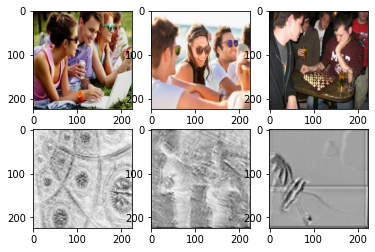

In [22]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
img1=plt.imread('ccv_data/test/images/1671.jpg')
img2=plt.imread('ccv_data/test/images/1672.jpg')
img3=plt.imread('ccv_data/test/images/1673.jpg')
img4=plt.imread('ccv_data/test/images/1681.jpg')
img5=plt.imread('ccv_data/test/images/1682.jpg')
img6=plt.imread('ccv_data/test/images/1683.jpg')
img7=plt.imread('predictions/test_predictions/1671_prediction.jpeg')
img8=plt.imread('predictions/test_predictions/1672_prediction.jpeg')
img9=plt.imread('predictions/test_predictions/1673_prediction.jpeg')
img10=plt.imread('predictions/test_predictions/1681_prediction.jpeg')
img11=plt.imread('predictions/test_predictions/1682_prediction.jpeg')
img12=plt.imread('predictions/test_predictions/1683_prediction.jpeg')
plt.figure(1)
plt.subplot(2,3,1)
plt.imshow(img1, cmap='binary')

plt.subplot(2,3,2)
plt.imshow(img2, cmap='binary')

plt.subplot(2,3,3)
plt.imshow(img3, cmap='binary')

plt.subplot(2,3,4)
plt.imshow(img7, cmap='binary')
plt.subplot(2,3,5)
plt.imshow(img8, cmap='binary')

plt.subplot(2,3,6)
plt.imshow(img9, cmap='binary')


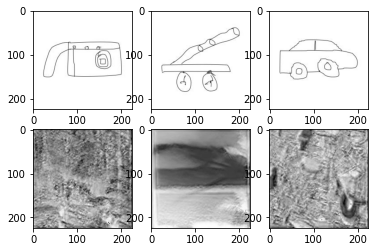

In [23]:
plt.figure(2)
plt.subplot(2,3,1)
plt.imshow(img4, cmap='binary')
plt.subplot(2,3,2)
plt.imshow(img5, cmap='binary')

plt.subplot(2,3,3)
plt.imshow(img6, cmap='binary')

plt.subplot(2,3,4)
plt.imshow(img10, cmap='binary')

plt.subplot(2,3,5)
plt.imshow(img11, cmap='binary')

plt.subplot(2,3,6)
plt.imshow(img12, cmap='binary')
plt.show()